In [285]:
import numpy as np 
import pandas as pd 
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.layers import Dropout
from keras import optimizers


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/wine-quality-dataset/WineQT.csv
/kaggle/input/playground-series-s3e5/sample_submission.csv
/kaggle/input/playground-series-s3e5/train.csv
/kaggle/input/playground-series-s3e5/test.csv


In [286]:
orig = pd.read_csv('/kaggle/input/wine-quality-dataset/WineQT.csv')
train = pd.read_csv('/kaggle/input/playground-series-s3e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e5/test.csv')

In [287]:
orig.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [288]:
orig['quality'].value_counts()

5    483
6    462
7    143
4     33
8     16
3      6
Name: quality, dtype: int64

In [289]:
train['quality'].value_counts()

5    839
6    778
7    333
4     55
8     39
3     12
Name: quality, dtype: int64

In [290]:
train = pd.concat([train,orig]).reset_index(drop=True)

train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

In [291]:
train.head()

,Id,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6


In [292]:
train['quality'].value_counts()

5    1322
6    1240
7     476
4      88
8      55
3      18
Name: quality, dtype: int64

In [293]:
train.shape

(3199, 13)

In [294]:
train = train.drop(train[train.quality==5][:650].index)
train = train.drop(train[train.quality==6][:550].index)

In [295]:
train.describe()

,Id,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000,1999.000000
mean,1060.921461,8.348524,0.521062,0.272671,2.483517,0.084595,16.143322,45.706603,0.996661,3.312866,0.663387,10.530757,5.841921
std,591.887368,1.751466,0.179718,0.194041,1.175331,0.038939,10.110010,31.188970,0.001877,0.149520,0.158939,1.096872,0.957570
min,0.000000,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,547.500000,7.100000,0.380000,0.100000,1.900000,0.070000,7.000000,21.000000,0.995460,3.210000,0.560000,9.600000,5.000000
50%,1086.000000,7.900000,0.510000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996600,3.310000,0.630000,10.300000,6.000000
75%,1573.000000,9.200000,0.635000,0.430000,2.600000,0.090000,23.000000,61.000000,0.997800,3.400000,0.740000,11.300000,7.000000
max,2055.000000,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


<AxesSubplot:>

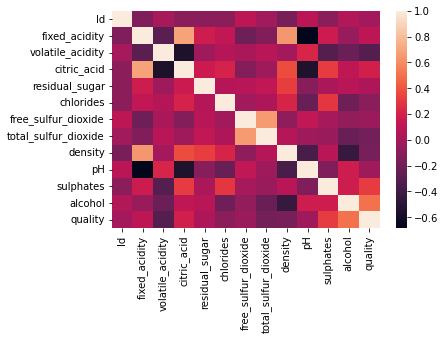

In [296]:
sns.heatmap(train.corr())

In [297]:
def FE(X):
    New_X = pd.DataFrame()
    New_X['total_acid'] = X['fixed_acidity'] + X['volatile_acidity'] + X['citric_acid']
    print(New_X['total_acid'])
    New_X['acid / density'] = New_X['total_acid']  / X['density']
    New_X['alcohol_density'] = X['alcohol']  * X['density']
    New_X['sulphate/density'] =New_X['total_acid']  / X['density']
    New_X['sulphates/acid'] = X['sulphates'] / X['volatile_acidity']
    New_X['sulphates/chlorines'] = X['sulphates'] / X['chlorides']
    New_X['sulphates*alcohol'] = X['sulphates'] * X['alcohol']
    return New_X


2        7.640
11      11.060
13       7.500
16      12.370
19       6.150
         ...  
3194     6.940
3195     7.500
3196     6.880
3197     6.550
3198     6.665
Name: total_acid, Length: 1999, dtype: float64


<AxesSubplot:>

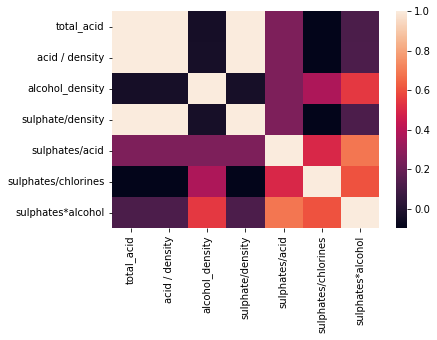

In [298]:
# X_train = train.iloc[:,1:12]
# y_train = train.quality

X_train = train.iloc[:,1:-1]
y_train = train.quality

X_train = FE(X_train)

sns.heatmap(X_train.corr())

In [299]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [300]:
pd.DataFrame(y_train).value_counts()

quality
6          464
5          435
7          328
4           58
8           41
3           13
dtype: int64

In [301]:
y_train_bin = np_utils.to_categorical(y_train)
y_test_bin = np_utils.to_categorical(y_test)

In [302]:
y_train_bin.shape

(1339, 9)

In [303]:
X_train.shape[1]

7

In [304]:

info_models = []
model = Sequential()
model.add(Dense(X_train.shape[1]-3, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dropout(.9))
# model.add(Dense(6, activation='relu'))
model.add(Dense(5, activation='relu' ))
# model.add(Dense(15, activation='relu' ))
# model.add(Dropout(.4))
# model.add(Dropout(.5))
model.add(Dense(9, activation='softmax'))
  # Compiling model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=['accuracy'])
model2 = model
j_model = model.to_json()

for _ in range(1):
    model = keras.models.model_from_json(j_model)
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=['accuracy'])
        # Training a model
    model.fit(X_train, y_train_bin, epochs=200, batch_size=10,verbose=0);
    scores = model.evaluate(X_test, y_test_bin)
    score = scores[1]*100
    info_model = {'score':score,'weights':model.get_weights()}
    info_models.append(info_model.copy())
    print("\nAccuracy: %.2f%%" % (scores[1]*100))
scores = [score.get('score') for score in info_models]
print(max(scores))


21/21 [==============================] - 0s 2ms/step - loss: 1.1400 - accuracy: 0.5333

Accuracy: 53.33%
53.33333611488342


In [305]:
scores = [score.get('score') for score in info_models]
print(scores.index(max(scores)))
max_index = scores.index(max(scores))
weights = info_models[max_index].get('weights')

0


In [306]:
model2.set_weights(weights)

In [307]:
scores = model2.evaluate(X_test, y_test_bin)
print("\nAccuracy: %.2f%%" % (scores[1]*100))


21/21 [==============================] - 0s 2ms/step - loss: 1.1400 - accuracy: 0.5333

Accuracy: 53.33%


In [308]:
X_train.shape

(1339, 7)

In [309]:
df_test = FE(test)

0        7.720
1        8.105
2        9.260
3        8.870
4        7.160
         ...  
1367     9.725
1368    16.390
1369     8.060
1370     8.640
1371     9.800
Name: total_acid, Length: 1372, dtype: float64


In [310]:
df_test.iloc[:,:]

,total_acid,acid / density,alcohol_density,sulphate/density,sulphates/acid,sulphates/chlorines,sulphates*alcohol
0,7.720,7.739504,9.775304,7.739504,1.156863,7.662338,5.782
1,8.105,8.138694,9.958600,8.138694,0.900662,6.666667,6.800
2,9.260,9.280975,9.478530,9.280975,1.413043,10.000000,6.175
3,8.870,8.916365,11.639160,8.916365,1.382979,11.607143,7.605
4,7.160,7.206409,12.717568,7.206409,1.411765,10.909091,6.144
...,...,...,...,...,...,...,...
1367,9.725,9.742244,9.782654,9.742244,0.939597,8.333333,6.860
1368,16.390,16.435362,10.072124,16.435362,3.208333,12.419355,7.777
1369,8.060,8.069684,9.388720,8.069684,0.789474,6.315789,5.640
1370,8.640,8.673305,9.861984,8.673305,0.679487,4.491525,5.247


In [311]:
predictions = model2.predict(scaler.fit_transform(df_test.iloc[:,:]))

In [312]:
class_pred = []
for col in predictions:
    class_pred.append(col.argmax())

In [313]:
submission = pd.DataFrame({'Id': test.Id, 'quality': class_pred})
submission.head()

,Id,quality
0,2056,5
1,2057,5
2,2058,5
3,2059,7
4,2060,7


In [314]:
submission['quality'].value_counts()

5    541
6    511
7    319
4      1
Name: quality, dtype: int64

In [315]:
submission.to_csv('sub.csv',index=False)